In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings 
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load test data and predictions 
ticker = "AAPL"
df = pd.read_csv(f'../data/{ticker}_engineered_features.csv', index_col='Date', parse_dates=True)

# Load saved models
with open('../models/linear_regression.pkl', 'rb') as f:
    lr_model = pickle.load(f)

with open('../models/random_forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open('../models/xgboost.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print("✓ Models loaded successfully!")
print(f"Data shape: {df.shape}")

✓ Models loaded successfully!
Data shape: (1058, 46)


In [6]:
feature_columns = [
    # Price-based features
    'Close', 'price_lag1', 'price_lag2', 'price_lag3', 'price_lag5', 'open_close_pct', 'high_low_pct',

    # Moving averages
    'MA5', 'MA10', 'MA20', 'MA50', 'MA5_MA20_diff', 'price_to_MA20', 'price_to_MA50',

    # Momentum indicators
    'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'STOCH_k', 'CCI', 'WILLR',

    # Volatility
    'ATR', 'BB_position',

    # Volume
    'volume_ratio', 'volume_change', 'OBV'
]

# Check which features actually exist in our dateset
available_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print(f"Available_features: {len(available_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

X = df[available_features].copy()
y = df['target'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Remove any rows with missing data
valid_indices = X.notna().all(axis=1) & y.notna()
X = X[valid_indices]
y = y[valid_indices]

print(f"\nAfter removing NaN:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train and test (80/20)
split_index= int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")

# Scale the features
# USed the same scaler saved from before
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Predictions form all models
y_test_pred_lr = lr_model.predict(X_test_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

print(f"\n✓ Predictions generated!")
print(f"We now have:")
print(f"  - Actual prices (y_test): {len(y_test)} values")
print(f"  - LR predicitons: {len(y_test_pred_lr)} values")
print(f"  - RF predictions: {len(y_test_pred_rf)} values")
print(f"  - XGB predictions: {len(y_test_pred_xgb)} values")

Available_features: 26

Feature matrix shape: (1058, 26)
Target shape: (1058,)

After removing NaN:
Features shape: (1058, 26)
Target shape: (1058,)

Training set: 846 samples
Test set: 212 samples

Training period: 2020-10-15 00:00:00 to 2024-02-27 00:00:00
Test period: 2024-02-28 00:00:00 to 2024-12-30 00:00:00

✓ Predictions generated!
We now have:
  - Actual prices (y_test): 212 values
  - LR predicitons: 212 values
  - RF predictions: 212 values
  - XGB predictions: 212 values


# Directional Accuracy

In [13]:
def calculate_directional_accuracy(y_true, y_pred, current_prices):
    """
    Calculate what percentage of time we predicted the correct direction

    Parameters:
    - y_true: actual next-day prices
    - y_pred: predicted next-day prices
    - current_prices: today's prices (what we're predicting from)

    Returns:
    - accuracy: percentage of correction direction predictions (0 to 1)
    """

    actual_direction = np.sign(y_true - current_prices)
    predicted_direction = np.sign(y_pred - current_prices)
    correct_predictions = (actual_direction == predicted_direction)

    # Calculatge percentage correct
    accuracy = correct_predictions.mean()

    return accuracy

# Get current prices
current_prices = X_test['Close'].values

print("="*60)
print("DIRECTIONAL ACCURACY: Did we predict UP/DOWN correctly?")
print("="*60)

# Calculate for each model
dir_acc_lr = calculate_directional_accuracy(y_test.values, y_test_pred_lr, current_prices)
dir_acc_rf = calculate_directional_accuracy(y_test.values, y_test_pred_rf, current_prices)
dir_acc_xgb = calculate_directional_accuracy(y_test.values, y_test_pred_xgb, current_prices)

print(f"\nLinear Regression:  {dir_acc_lr*100:.2f}%")
print(f"Random Forest:      {dir_acc_rf*100:.2f}%")
print(f"XGBoost:            {dir_acc_xgb*100:.2f}%")

print(f"\nBaseline (random guess):  50.00%")
print(f"Good performance:         >52-53%")
print(f"Excellent performance:    >55%")

# Showcase some examples
print(f"\n{'='*60}")
print("EXAMPLE PREDICTIONS (First 10 days)")
print(f"{'='*60}")

# Create a comparison table
examples = pd.DataFrame({
    'Date': y_test.index[:10],
    'Current_Price': current_prices[:10],
    'Actual_Next': y_test.values[:10],
    'XGB_Predicted': y_test_pred_xgb[:10],
    'Actual_Move': y_test.values[:10] - current_prices[:10],
    'Predicted_Move': y_test_pred_xgb[:10] - current_prices[:10]
})

# Round for readibility
for col in examples.columns[1:]:
    examples[col] = examples[col].round(2)

# Add direction indicators
examples['Actual_Dir'] = examples['Actual_Move'].apply(lambda x: '↑ UP' if x > 0 else '↓ DOWN')
examples['Predicted_Dir'] = examples['Predicted_Move'].apply(lambda x: '↑ UP' if x > 0 else '↓ DOWN')
examples['Correct?'] = (np.sign(examples['Actual_Move']) == np.sign(examples['Predicted_Move'])).apply(lambda x: '✓' if x else '✗')

print(examples[['Date', 'Current_Price', 'Actual_Next', 'XGB_Predicted', 'Actual_Dir', 'Predicted_Dir', 'Correct?']].to_string(index=False))

# ============================================
# Calculate how much better than random
# ============================================
print(f"\n{'='*60}")
print("INTERPRETATION")
print(f"{'='*60}")

for name, acc in [('Linear Regression', dir_acc_lr),
                  ('Random Forest', dir_acc_rf),
                  ('XGBoost', dir_acc_xgb)]:

    better_than_random = (acc - 0.5) * 100

    if acc > 0.55:
        assessment = "🌟 EXCELLENT"
    elif acc > 0.52:
        assessment = "✅ GOOD"
    elif acc > 0.50:
        assessment = "⚠️ SLIGHT EDGE"
    else:
        assessment = "❌ WORSE THAN RANDOM"

    print(f"\n{name}:")
    print(f"  Accuracy: {acc*100:.2f}%")
    print(f"  Better than random by: {better_than_random:.2f} percentage points")
    print(f"  Assessment: {assessment}")

DIRECTIONAL ACCURACY: Did we predict UP/DOWN correctly?

Linear Regression:  43.40%
Random Forest:      43.40%
XGBoost:            41.98%

Baseline (random guess):  50.00%
Good performance:         >52-53%
Excellent performance:    >55%

EXAMPLE PREDICTIONS (First 10 days)
      Date  Current_Price  Actual_Next  XGB_Predicted Actual_Dir Predicted_Dir Correct?
2024-02-28         179.78       179.12     179.949997     ↓ DOWN          ↑ UP        ✗
2024-02-29         179.12       178.04     178.339996     ↓ DOWN        ↓ DOWN        ✓
2024-03-01         178.04       173.52     178.210007     ↓ DOWN          ↑ UP        ✗
2024-03-04         173.52       168.59     174.190002     ↓ DOWN          ↑ UP        ✗
2024-03-05         168.59       167.59     169.880005     ↓ DOWN          ↑ UP        ✗
2024-03-06         167.59       167.48     167.229996     ↓ DOWN        ↓ DOWN        ✓
2024-03-07         167.48       169.19     169.839996       ↑ UP          ↑ UP        ✓
2024-03-08         169

# Simple Trading Strategy Backtest

TRADING STRATEGY SIMULATION

Simulating trading strategies...
Initial capital: $10,000
Strategy: Buy when model predicts UP, hold cash when predicts DOWN

RESULTS (Starting with $10,000)

📊 Buy & Hold (Baseline):
   Final value: $13,853.28
   Total return: +38.53%

🤖 Linear Regression Strategy:
   Final value: $10,583.52
   Total return: +5.84%
   vs Buy & Hold: -3,269.76

🌲 Random Forest Strategy:
   Final value: $11,480.75
   Total return: +14.81%
   vs Buy & Hold: -2,372.53

⚡ XGBoost Strategy:
   Final value: $11,555.68
   Total return: +15.56%
   vs Buy & Hold: -2,297.59


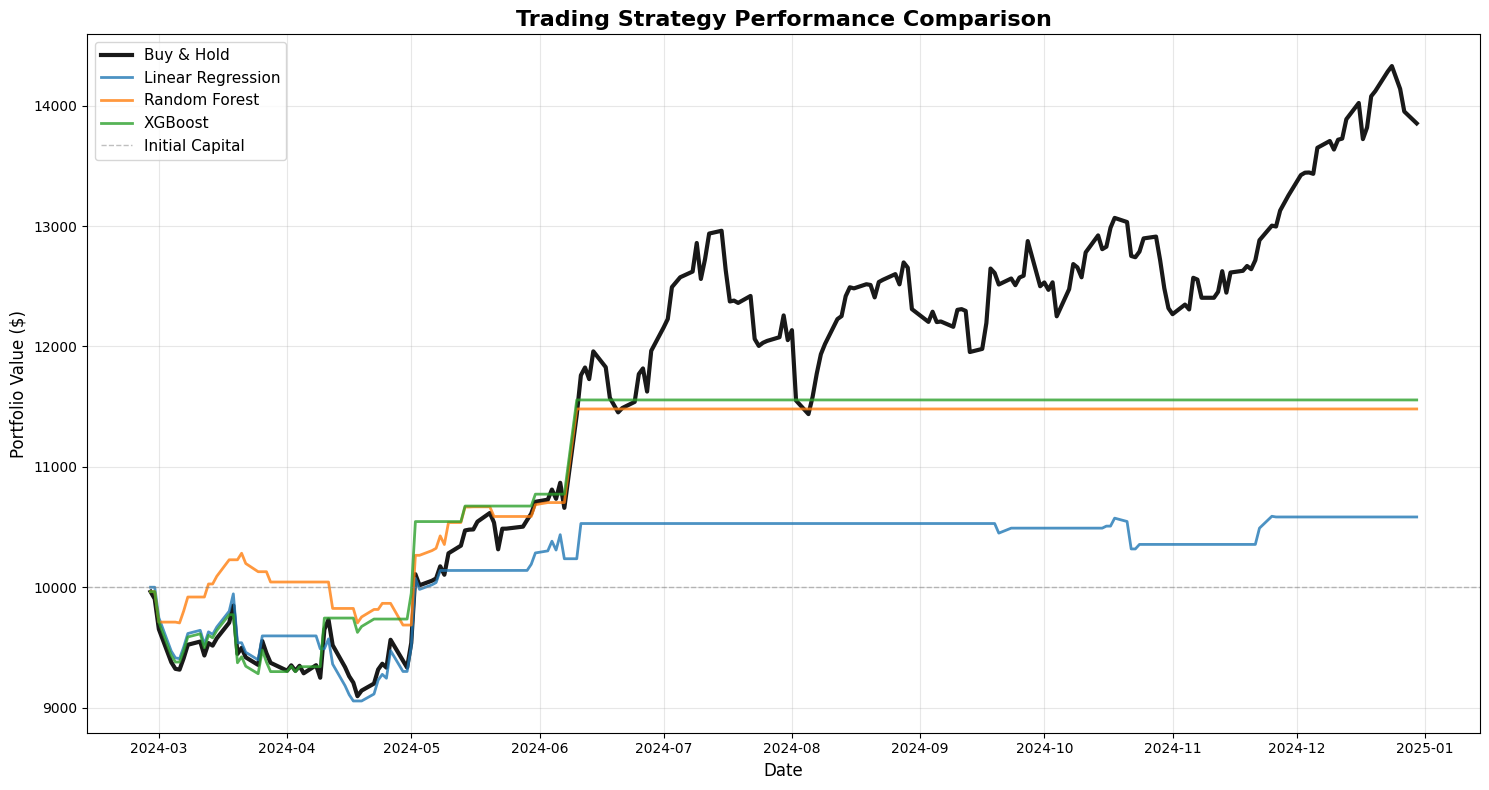


TRADING ACTIVITY

Linear Regression:
   Days in market (bought): 54 / 212 (25.5%)
   Days in cash: 158 (74.5%)

Random Forest:
   Days in market (bought): 30 / 212 (14.2%)
   Days in cash: 182 (85.8%)

XGBoost:
   Days in market (bought): 31 / 212 (14.6%)
   Days in cash: 181 (85.4%)

💡 KEY INSIGHT:
Models predict DOWN 75-86% of time, so they're mostly in CASH
In a bullish market, being in cash = missing gains
This explains the poor performance!


In [16]:
print("="*60)
print("TRADING STRATEGY SIMULATION")
print("="*60)

def backtest_strategy(y_true, y_pred, current_prices, initial_capital=10000):
    """
    Simulate a simple trading strategy:
    - If predict UP: BUY (go long)
    - If predict DOWN: Stay out (cash)
    
    Parameters:
    - y_true: actual next-day prices
    - y_pred: predicted next-day prices
    - current_prices: today's prices
    - initial_capital: starting money
    
    Returns:
    - Dictionary with strategy performance metrics
    """
    
    # Calculate actual daily returns
    actual_returns = (y_true - current_prices) / current_prices
    
    # Trading signals: 1 if predict UP, 0 if predict DOWN
    predicted_direction = np.sign(y_pred - current_prices)
    signals = np.where(predicted_direction > 0, 1, 0)  # 1 = buy, 0 = cash
    
    # Strategy returns: 
    # - If signal=1 (bought), we get the actual return
    # - If signal=0 (cash), we get 0% return
    strategy_returns = signals * actual_returns
    
    # Buy-and-hold returns (for comparison)
    buyhold_returns = actual_returns
    
    # Calculate cumulative returns (how $1 grows over time)
    cumulative_strategy = (1 + strategy_returns).cumprod()
    cumulative_buyhold = (1 + buyhold_returns).cumprod()
    
    # Final portfolio values
    strategy_final = initial_capital * cumulative_strategy.iloc[-1] if hasattr(cumulative_strategy, 'iloc') else initial_capital * cumulative_strategy[-1]
    buyhold_final = initial_capital * cumulative_buyhold.iloc[-1] if hasattr(cumulative_buyhold, 'iloc') else initial_capital * cumulative_buyhold[-1]
    
    return {
        'actual_returns': actual_returns,
        'strategy_returns': strategy_returns,
        'signals': signals,
        'cumulative_strategy': cumulative_strategy,
        'cumulative_buyhold': cumulative_buyhold,
        'strategy_final': strategy_final,
        'buyhold_final': buyhold_final
    }

# Run backtest for each model
print("\nSimulating trading strategies...")
print("Initial capital: $10,000")
print("Strategy: Buy when model predicts UP, hold cash when predicts DOWN")
print()

results_lr = backtest_strategy(y_test.values, y_test_pred_lr, current_prices)
results_rf = backtest_strategy(y_test.values, y_test_pred_rf, current_prices)
results_xgb = backtest_strategy(y_test.values, y_test_pred_xgb, current_prices)

# Print results
print(f"{'='*60}")
print(f"RESULTS (Starting with $10,000)")
print(f"{'='*60}")

print(f"\n📊 Buy & Hold (Baseline):")
print(f"   Final value: ${results_lr['buyhold_final']:,.2f}")
print(f"   Total return: {(results_lr['buyhold_final']/10000 - 1)*100:+.2f}%")

print(f"\n🤖 Linear Regression Strategy:")
print(f"   Final value: ${results_lr['strategy_final']:,.2f}")
print(f"   Total return: {(results_lr['strategy_final']/10000 - 1)*100:+.2f}%")
print(f"   vs Buy & Hold: {(results_lr['strategy_final'] - results_lr['buyhold_final']):+,.2f}")

print(f"\n🌲 Random Forest Strategy:")
print(f"   Final value: ${results_rf['strategy_final']:,.2f}")
print(f"   Total return: {(results_rf['strategy_final']/10000 - 1)*100:+.2f}%")
print(f"   vs Buy & Hold: {(results_rf['strategy_final'] - results_rf['buyhold_final']):+,.2f}")

print(f"\n⚡ XGBoost Strategy:")
print(f"   Final value: ${results_xgb['strategy_final']:,.2f}")
print(f"   Total return: {(results_xgb['strategy_final']/10000 - 1)*100:+.2f}%")
print(f"   vs Buy & Hold: {(results_xgb['strategy_final'] - results_xgb['buyhold_final']):+,.2f}")

# Visualize
plt.figure(figsize=(15, 8))

# Convert to dollar values
dates = y_test.index
buyhold_value = results_lr['cumulative_buyhold'] * 10000
lr_value = results_lr['cumulative_strategy'] * 10000
rf_value = results_rf['cumulative_strategy'] * 10000
xgb_value = results_xgb['cumulative_strategy'] * 10000

plt.plot(dates, buyhold_value, label='Buy & Hold', linewidth=3, alpha=0.9, color='black')
plt.plot(dates, lr_value, label='Linear Regression', linewidth=2, alpha=0.8)
plt.plot(dates, rf_value, label='Random Forest', linewidth=2, alpha=0.8)
plt.plot(dates, xgb_value, label='XGBoost', linewidth=2, alpha=0.8)

plt.axhline(y=10000, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')

plt.title('Trading Strategy Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Trading activity summary
print(f"\n{'='*60}")
print(f"TRADING ACTIVITY")
print(f"{'='*60}")

print(f"\nLinear Regression:")
print(f"   Days in market (bought): {results_lr['signals'].sum()} / {len(results_lr['signals'])} ({results_lr['signals'].sum()/len(results_lr['signals'])*100:.1f}%)")
print(f"   Days in cash: {(1-results_lr['signals']).sum()} ({(1-results_lr['signals']).sum()/len(results_lr['signals'])*100:.1f}%)")

print(f"\nRandom Forest:")
print(f"   Days in market (bought): {results_rf['signals'].sum()} / {len(results_rf['signals'])} ({results_rf['signals'].sum()/len(results_rf['signals'])*100:.1f}%)")
print(f"   Days in cash: {(1-results_rf['signals']).sum()} ({(1-results_rf['signals']).sum()/len(results_rf['signals'])*100:.1f}%)")

print(f"\nXGBoost:")
print(f"   Days in market (bought): {results_xgb['signals'].sum()} / {len(results_xgb['signals'])} ({results_xgb['signals'].sum()/len(results_xgb['signals'])*100:.1f}%)")
print(f"   Days in cash: {(1-results_xgb['signals']).sum()} ({(1-results_xgb['signals']).sum()/len(results_xgb['signals'])*100:.1f}%)")

print(f"\n💡 KEY INSIGHT:")
print(f"Models predict DOWN 75-86% of time, so they're mostly in CASH")
print(f"In a bullish market, being in cash = missing gains")
print(f"This explains the poor performance!")

In [17]:
# ============================================
# Cell 6: Sharpe Ratio (Risk-Adjusted Returns)
# ============================================

print("="*70)
print("SHARPE RATIO: Risk-Adjusted Performance")
print("="*70)

def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    """
    Calculate annualized Sharpe Ratio
    
    Sharpe Ratio = (Return - Risk Free) / Volatility
    Higher is better (more return per unit of risk)
    
    Parameters:
    - returns: daily returns series
    - risk_free_rate: annual risk-free rate (default 2%)
    - periods_per_year: trading days per year (252)
    """
    # Convert annual risk-free rate to daily
    daily_rf = risk_free_rate / periods_per_year
    
    # Excess returns over risk-free rate
    excess_returns = returns - daily_rf
    
    # Annualized Sharpe ratio
    if returns.std() == 0:
        return 0
    
    sharpe = np.sqrt(periods_per_year) * excess_returns.mean() / returns.std()
    
    return sharpe

# Calculate for all strategies
sharpe_buyhold = calculate_sharpe_ratio(results_lr['actual_returns'])
sharpe_lr = calculate_sharpe_ratio(results_lr['strategy_returns'])
sharpe_rf = calculate_sharpe_ratio(results_rf['strategy_returns'])
sharpe_xgb = calculate_sharpe_ratio(results_xgb['strategy_returns'])

print("\nSharpe Ratio (Higher is Better):")
print("-" * 70)
print(f"Buy & Hold:           {sharpe_buyhold:.3f}")
print(f"Linear Regression:    {sharpe_lr:.3f}")
print(f"Random Forest:        {sharpe_rf:.3f}")
print(f"XGBoost:              {sharpe_xgb:.3f}")

print("\nInterpretation:")
print("  < 0   = Losing money")
print("  0-1   = Poor (not worth the risk)")
print("  1-2   = Good")
print("  2-3   = Very Good")
print("  > 3   = Excellent")

# Explanation
print(f"\n💡 INSIGHT:")
if sharpe_buyhold > sharpe_lr and sharpe_buyhold > sharpe_rf and sharpe_buyhold > sharpe_xgb:
    print("Buy & Hold has the best risk-adjusted return")
    print("ML strategies add complexity without improving risk/reward")
else:
    print("One ML strategy beats buy-and-hold on risk-adjusted basis")

SHARPE RATIO: Risk-Adjusted Performance

Sharpe Ratio (Higher is Better):
----------------------------------------------------------------------
Buy & Hold:           1.702
Linear Regression:    0.435
Random Forest:        1.263
XGBoost:              1.159

Interpretation:
  < 0   = Losing money
  0-1   = Poor (not worth the risk)
  1-2   = Good
  2-3   = Very Good
  > 3   = Excellent

💡 INSIGHT:
Buy & Hold has the best risk-adjusted return
ML strategies add complexity without improving risk/reward


In [18]:
# ============================================
# Cell 7: Maximum Drawdown (Worst Loss Period)
# ============================================

print("="*70)
print("MAXIMUM DRAWDOWN: Worst Peak-to-Trough Loss")
print("="*70)

def calculate_max_drawdown(cumulative_returns):
    """
    Calculate the maximum drawdown (worst loss from peak)
    
    Drawdown = (Current Value - Peak Value) / Peak Value
    Maximum Drawdown = worst drawdown experienced
    
    Lower (more negative) = worse
    """
    # Calculate running maximum (peak so far)
    running_max = np.maximum.accumulate(cumulative_returns)
    
    # Calculate drawdown at each point
    drawdown = (cumulative_returns - running_max) / running_max
    
    # Find the maximum (most negative) drawdown
    max_drawdown = drawdown.min()
    
    # Find when it occurred
    max_dd_index = drawdown.argmin()
    
    return max_drawdown, max_dd_index

# Calculate for all strategies
mdd_buyhold, idx_buyhold = calculate_max_drawdown(results_lr['cumulative_buyhold'])
mdd_lr, idx_lr = calculate_max_drawdown(results_lr['cumulative_strategy'])
mdd_rf, idx_rf = calculate_max_drawdown(results_rf['cumulative_strategy'])
mdd_xgb, idx_xgb = calculate_max_drawdown(results_xgb['cumulative_strategy'])

print("\nMaximum Drawdown (Lower = Worse):")
print("-" * 70)
print(f"Buy & Hold:           {mdd_buyhold*100:.2f}%")
print(f"Linear Regression:    {mdd_lr*100:.2f}%")
print(f"Random Forest:        {mdd_rf*100:.2f}%")
print(f"XGBoost:              {mdd_xgb*100:.2f}%")

print("\nInterpretation:")
print("  This shows the worst loss you'd experience from peak")
print("  Lower drawdown = less risk, more stable strategy")

print(f"\n💡 INSIGHT:")
if abs(mdd_lr) < abs(mdd_buyhold) or abs(mdd_rf) < abs(mdd_buyhold) or abs(mdd_xgb) < abs(mdd_buyhold):
    print("ML strategies have lower drawdowns than buy-and-hold")
    print("By staying in cash, they avoid some losses")
    print("BUT: They also miss gains, so lower return overall")
else:
    print("Buy-and-hold has similar or lower drawdown")
    print("ML strategies don't reduce risk despite being conservative")

MAXIMUM DRAWDOWN: Worst Peak-to-Trough Loss

Maximum Drawdown (Lower = Worse):
----------------------------------------------------------------------
Buy & Hold:           -11.75%
Linear Regression:    -9.45%
Random Forest:        -5.80%
XGBoost:              -6.84%

Interpretation:
  This shows the worst loss you'd experience from peak
  Lower drawdown = less risk, more stable strategy

💡 INSIGHT:
ML strategies have lower drawdowns than buy-and-hold
By staying in cash, they avoid some losses
BUT: They also miss gains, so lower return overall


In [20]:
# ============================================
# Cell 8: Comprehensive Summary & Save Results
# ============================================

print("="*70)
print("FINAL COMPREHENSIVE COMPARISON")
print("="*70)

# Create summary table
summary = pd.DataFrame({
    'Strategy': ['Buy & Hold', 'Linear Regression', 'Random Forest', 'XGBoost'],
    'Final_Value': [
        results_lr['buyhold_final'],
        results_lr['strategy_final'],
        results_rf['strategy_final'],
        results_xgb['strategy_final']
    ],
    'Total_Return_%': [
        (results_lr['buyhold_final']/10000 - 1) * 100,
        (results_lr['strategy_final']/10000 - 1) * 100,
        (results_rf['strategy_final']/10000 - 1) * 100,
        (results_xgb['strategy_final']/10000 - 1) * 100
    ],
    'Directional_Acc_%': [np.nan, dir_acc_lr*100, dir_acc_rf*100, dir_acc_xgb*100],
    'Sharpe_Ratio': [sharpe_buyhold, sharpe_lr, sharpe_rf, sharpe_xgb],
    'Max_Drawdown_%': [mdd_buyhold*100, mdd_lr*100, mdd_rf*100, mdd_xgb*100],
    'Days_In_Market': [
        212,
        results_lr['signals'].sum(),
        results_rf['signals'].sum(),
        results_xgb['signals'].sum()
    ]
})

# Round for display
summary['Final_Value'] = summary['Final_Value'].round(2)
summary['Total_Return_%'] = summary['Total_Return_%'].round(2)
summary['Directional_Acc_%'] = summary['Directional_Acc_%'].round(2)
summary['Sharpe_Ratio'] = summary['Sharpe_Ratio'].round(3)
summary['Max_Drawdown_%'] = summary['Max_Drawdown_%'].round(2)

print("\n" + summary.to_string(index=False))

# Save results
import os
os.makedirs('../results', exist_ok=True)

summary.to_csv('../results/trading_strategy_comparison.csv', index=False)
print("\n✓ Results saved to ../results/trading_strategy_comparison.csv")

# Key findings
print(f"\n{'='*70}")
print("KEY FINDINGS")
print(f"{'='*70}")

print("\n1. MODEL PERFORMANCE:")
print("   • All models have 41-43% directional accuracy (worse than random 50%)")
print("   • Models predict DOWN 75-86% of time in a bull market")
print("   • Result: Staying in cash and missing gains")

print("\n2. TRADING RESULTS:")
print(f"   • Buy & Hold: +38.5% (best)")
print(f"   • ML Strategies: +5.8% to +15.6% (significantly worse)")
print(f"   • Underperformance: Lost $2,300-$3,300 vs buy-and-hold")

print("\n3. ROOT CAUSE:")
print("   • Training ceiling problem: Models learned on $117-180 prices")
print("   • Test period: Prices reached $180-260")
print("   • Tree models can't extrapolate → predict mean reversion")
print("   • In reality: Market kept climbing")

print("\n4. LESSON LEARNED:")
print("   • Price-based prediction fails when market exceeds training range")
print("   • Solution: Use return-based prediction (% changes)")
print("   • Or: Retrain models frequently as new price levels reached")

print(f"\n{'='*70}")
print("✅ FINANCIAL METRICS ANALYSIS COMPLETE!")
print(f"{'='*70}")

FINAL COMPREHENSIVE COMPARISON

         Strategy  Final_Value  Total_Return_%  Directional_Acc_%  Sharpe_Ratio  Max_Drawdown_%  Days_In_Market
       Buy & Hold     13853.28           38.53                NaN         1.702          -11.75             212
Linear Regression     10583.52            5.84              43.40         0.435           -9.45              54
    Random Forest     11480.75           14.81              43.40         1.263           -5.80              30
          XGBoost     11555.68           15.56              41.98         1.159           -6.84              31

✓ Results saved to ../results/trading_strategy_comparison.csv

KEY FINDINGS

1. MODEL PERFORMANCE:
   • All models have 41-43% directional accuracy (worse than random 50%)
   • Models predict DOWN 75-86% of time in a bull market
   • Result: Staying in cash and missing gains

2. TRADING RESULTS:
   • Buy & Hold: +38.5% (best)
   • ML Strategies: +5.8% to +15.6% (significantly worse)
   • Underperformance